In [7]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import os

In [ ]:
# No arquivo .py estava fazendo assim:
# print("Carregar o Dataset Global")
# pasta_atual = os.path.dirname(os.path.abspath(__file__))

# caminho_csv = os.path.join(pasta_atual, 'dataset.csv')
# caminho_json = os.path.join(pasta_atual, 'YourSoundCapsule.json')

caminho_csv = 'dataset.csv'
caminho_json = 'YourSoundCapsule.json'
df_kaggle = pd.read_csv(caminho_csv)


df_model = df_kaggle[(df_kaggle['valence'] < 0.4) | (df_kaggle['valence'] > 0.6)].copy()
df_model['emotion'] = np.where(df_model['valence'] > 0.6, 1, 0) # 1 = Feliz, 0 = Triste

features = ['tempo', 'energy', 'loudness', 'danceability', 'acousticness']

X = df_model[features]
y = df_model['emotion']

In [9]:
#  70%  treino 30%  teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Treino da Inteligência Artificial (Random Forest).")
# 100 árvores de decisão, 42 para reprodutibilidade, n_jobs=-1 para usar todos os núcleos do processador
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo_rf.fit(X_train, y_train)

y_pred_global = modelo_rf.predict(X_test)

print()
print("Desempenho do Modelo no Dataset")
print()
print(classification_report(y_test, y_pred_global))
print(f"Acurácia Geral do Modelo: {accuracy_score(y_test, y_pred_global)*100:.2f}%")

Treino da Inteligência Artificial (Random Forest).

Desempenho do Modelo no Dataset

              precision    recall  f1-score   support

           0       0.86      0.87      0.86     14627
           1       0.83      0.82      0.82     11497

    accuracy                           0.85     26124
   macro avg       0.84      0.84      0.84     26124
weighted avg       0.85      0.85      0.85     26124

Acurácia Geral do Modelo: 84.60%


In [10]:
print("\nLer histórico musical")
with open(caminho_json, encoding='utf-8') as f:
    capsule_data = json.load(f)

historico = []
for stat in capsule_data['stats']:
    for track in stat.get('topTracks', []):
        historico.append({'track_name': track['name']})

df_user = pd.DataFrame(historico).drop_duplicates()

df_user['match_name'] = df_user['track_name'].str.lower().str.strip()
df_kaggle['match_name'] = df_kaggle['track_name'].astype(str).str.lower().str.strip()


Ler histórico musical


In [11]:
df_kaggle_unique = df_kaggle.drop_duplicates(subset=['match_name']).copy()

# Cruzando do JSON com as features do CSV, pois a api do spotify não estava funcionando, peguei um dataset de 114 mil músicas para ter as informações
df_suas_musicas = pd.merge(df_user, df_kaggle_unique, on='match_name', how='inner')

df_suas_musicas = df_suas_musicas.rename(columns={'track_name_x': 'track_name'})

print(f"Encontradas {len(df_suas_musicas)} músicas no banco de dados.")


Encontradas 31 músicas no banco de dados.



Previsões

                track_name Previsao_Modelo  Certeza_%
                     Ashes          Triste       84.0
                 Faz assim          Triste       89.0
       Stuck In The Middle           Feliz       95.0
           One Step Closer          Triste       71.0
              BURN IT DOWN           Feliz       66.0
                  Papercut           Feliz       95.0
                     Faint           Feliz       78.0
              Bleed It Out           Feliz       93.0
               Scar Tissue           Feliz       68.0
            Snap Out Of It           Feliz       92.0
        Somewhere I Belong          Triste       56.0
    Feet Don't Fail Me Now           Feliz       98.0
Can't Help Falling in Love          Triste      100.0
     Welcome To The Jungle          Triste       96.0
                  Arabella           Feliz       62.0
            Rock That Body           Feliz       58.0
                 Otherside          Triste       70.0
            What

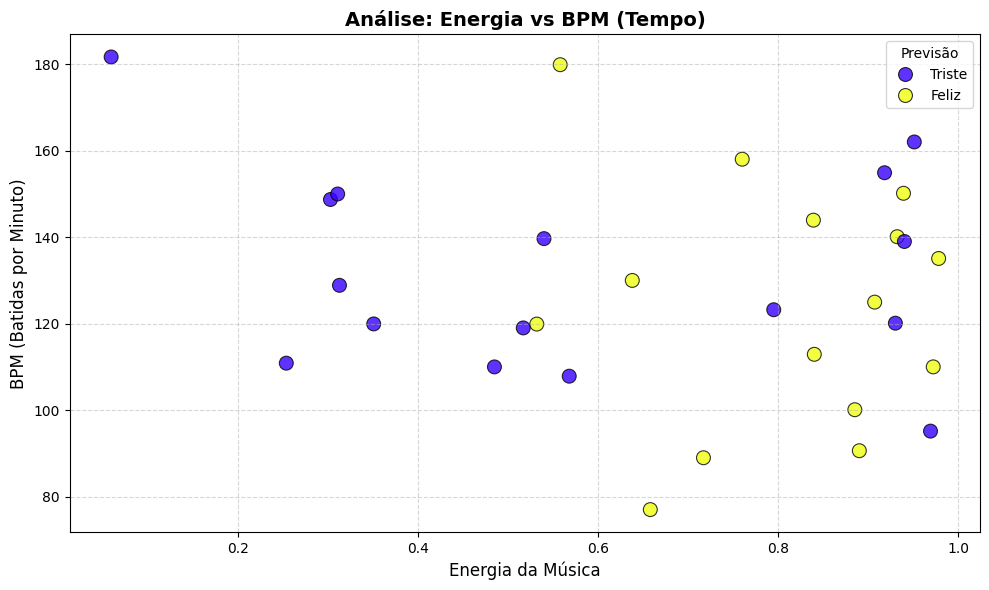

In [12]:
if len(df_suas_musicas) > 0:
    X_suas_musicas = df_suas_musicas[features]
    
    suas_previsoes = modelo_rf.predict(X_suas_musicas)
    suas_probabilidades = modelo_rf.predict_proba(X_suas_musicas)[:, 1]
    
    df_suas_musicas['Previsao_Modelo'] = ['Feliz' if p == 1 else 'Triste' for p in suas_previsoes]
    df_suas_musicas['Certeza_%'] = (np.where(suas_previsoes == 1, suas_probabilidades, 1 - suas_probabilidades) * 100).round(2)
    
    print()
    print("Previsões")
    print()
    print(df_suas_musicas[['track_name', 'Previsao_Modelo', 'Certeza_%']].head(20).to_string(index=False))

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='energy', 
        y='tempo', 
        hue='Previsao_Modelo', 
        palette={'Feliz': "#efff11", 'Triste': "#3700ff"},
        data=df_suas_musicas, 
        s=100, 
        alpha=0.8,
        edgecolor='black'
    )
    
    plt.title('Análise: Energia vs BPM (Tempo)', fontsize=14, fontweight='bold')
    plt.xlabel('Energia da Música', fontsize=12)
    plt.ylabel('BPM (Batidas por Minuto)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Previsão')
    plt.tight_layout()
    plt.show()
    #para prosseguir quando rodar o código fechar o gráfico, ele fica preso no gráfico até ele ser fechado

else:
    print("Nenhuma música bateu com as músicas do dataset.")


Calculando a Importância das Variáveis.

Feature Importance

     Feature  Importancia
danceability     0.299453
      energy     0.204115
acousticness     0.181230
    loudness     0.159901
       tempo     0.155301


C:\Users\ruanlourenco-ieg\AppData\Local\Temp\ipykernel_75512\2990019987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=df_import, palette='viridis')


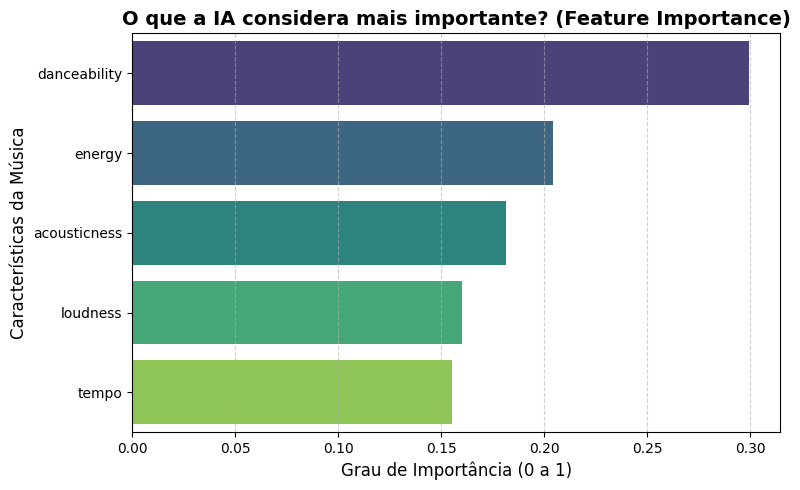

In [13]:

#Feature Importance - O que a IA considera mais importante para classificar uma música como feliz ou triste?
print("\nCalculando a Importância das Variáveis.")

imports = modelo_rf.feature_importances_

df_import = pd.DataFrame({'Feature': features, 'Importancia': imports})
df_import = df_import.sort_values(by='Importancia', ascending=False)

print()
print("Feature Importance")
print()
print(df_import.to_string(index=False))
plt.figure(figsize=(8, 5))
sns.barplot(x='Importancia', y='Feature', data=df_import, palette='viridis')
plt.title('O que a IA considera mais importante? (Feature Importance)', fontsize=14, fontweight='bold')
plt.xlabel('Grau de Importância (0 a 1)', fontsize=12)
plt.ylabel('Características da Música', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
